In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        if(msg_field.startswith("'cTrainingError")):
            msg_field = " ".join(fields[11:-1])
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,2
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,16
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15


In [6]:
# df.elapsed_time.value_counts()

In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,2,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,16,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'firebird'," "'monetdb'," "'mssql'," "'mysql'," "'oracle',"
 "'pgsql'," "'sqltm'," "'teradata',"]
df.shape (16519, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')


In [15]:
missing_data.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,EllipticEnvelope_pipe,"'p_DS_BENCH_O_200_82_2_7B21C547',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.covariance
1,NuSVC,"'DS_BENCH_C_200_82_10_EA8E6ACF',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.svm
2,NuSVC,"'DS_BENCH_C_200_82_4_DBD3B4F4',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.svm
3,NuSVC_pipe,"'p_DS_BENCH_C_200_82_10_EA8E6ACF',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.svm
4,NuSVC_pipe,"'p_DS_BENCH_C_200_82_4_DBD3B4F4',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.svm


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(16578, 8)

In [19]:
df.est_dialect.value_counts()

'mssql',       1842
'db2',         1842
'pgsql',       1842
'monetdb',     1842
'teradata',    1842
'firebird',    1842
'mysql',       1842
'oracle',      1842
'sqltm',       1842
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

error_message
est_dialect error_message                                                    
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                     136
'teradata', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   83
            TIMEOUT                                                        45
'db2',      "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'monetdb',  "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'teradata', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'sqltm',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'pgsql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'oracle',   "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'firebird', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'mysql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'mssql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   36
'oracle',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   27
'mysql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   26
'db2',      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   22
'teradata', 'DatabaseError:(teradata.api.DatabaseError)                    20
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   19
'pgsql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   18
'mssql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   18
'sqltm',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   18
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)                      15
'monetdb',  TIMEOUT                                                        12
'mysql',    'IndexError:list                                                6
'pgsql',    'IndexError:list                                                6
'firebird', 'IndexError:list                                                6
'oracle',   'IndexError:list                                                6
'sqltm',    'IndexError:list                                                6
'db2',      'IndexError:list                                                6
'teradata', 'IndexError:list                                                6
'mssql',    'IndexError:list                                                6
'monetdb',  'IndexError:list                                                6
'sqltm',    ) too many columns in result se                                 4
'pgsql',    ) target lists can have at most 1664 entrie                     4
'sqltm',    ) too many terms in compound SELEC                              4
'teradata', "DatabaseError:(teradata.api.DatabaseError)                     4
'db2',      : SQLNumResultCols failed: [IBM][CLI Driver][DB...              4
'oracle',   TIMEOUT                                                         2
'mssql',    8631, b'Internal error: Server stack limit has ...              2
'sqltm',    ) Expression tree is too large (maximum depth 1000              2
'monetdb',  'IntegrityError:COMMIT:                                         2
'db2',      'InternalError:(ibm_db_dbi.InternalError)                       2
'pgsql',    ) stack depth limit exceededHINT:  Increase the...              2
'mysql',    1436, "Thread stack overrun:  1237888 bytes use...              2
'sqltm',    'cTrainingError:ValueError:`min_samples` may no...              1
'firebird', 'cTrainingError:ValueError:`min_samples` may no...              1
'oracle',   'DatabaseError:(cx+Oracle.DatabaseError)                        1
'db2',      'cTrainingError:ValueError:`min_samples` may no...              1
'pgsql',    'cTrainingError:ValueError:`min_samples` may no...              1
'db2',      : Statement Execute Failed: [IBM][CLI Driver][D...              1
'oracle'

In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,15656
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",324
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",267
'DatabaseError:(fdb.fbcore.DatabaseError),136
TIMEOUT,59
'IndexError:list,54
'DatabaseError:(teradata.api.DatabaseError),20
"""DatabaseError:(fdb.fbcore.DatabaseError)",15
"'cTrainingError:ValueError:`min_samples` may not be larger than number of samples ``X.shape[0]``.'),",9
) too many columns in result se,4


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
real_errors = df[df.error_message == '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS']

In [27]:
real_errors.Model.value_counts()

OneVsOneClassifier                 54
OneVsOneClassifier_pipe            53
LinearDiscriminantAnalysis_pipe    45
FastICA                            16
ExtraTreesClassifier_pipe          14
FactorAnalysis                     12
LGBMClassifier_pipe                11
XGBRegressor                        9
ExtraTreesClassifier                8
XGBClassifier_pipe                  8
BaggingClassifier_pipe              6
BaggingClassifier                   6
AdaBoostClassifier                  5
AdaBoostClassifier_pipe             5
RandomForestClassifier              4
QuantileTransformer                 4
RandomForestClassifier_pipe         2
EllipticEnvelope                    2
ExtraTreesRegressor_pipe            1
IsolationForest                     1
IsolationForest_pipe                1
Name: Model, dtype: int64

In [28]:
lNotImplementedMessage = '"Exception:CODE_GENERATION_NOT_IMPLEMENTED'
not_impl_errors = df[df.error_message == lNotImplementedMessage]
not_impl_errors.Model.value_counts()

MiniBatchSparsePCA           108
SparsePCA                    108
LatentDirichletAllocation     54
NMF                           54
Name: Model, dtype: int64

In [29]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,2,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,16,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']
df = df[df['error_message'] != lNotImplementedMessage]



In [34]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,5,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,2,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,5,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,16,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,15,lightgbm.sklearn,1,db2


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                            \
dialect                         db2 firebird monetdb mssql mysql oracle pgsql   
model_category                                                                  
lightgbm.sklearn                 48       48      48    48    48     48    48   
sklearn.calibration              36       36      36    36    36     36    36   
sklearn.covariance               12       12      12    12    12     12    12   
sklearn.decomposition            72       72      72    72    72     72    72   
sklearn.discriminant_analysis    36       36      36    36    36     36    36   
sklearn.ensemble                252      252     252   252   252    252   252   
sklearn.feature_selection       108      108     108   108   108    108   108   
sklearn.kernel_ridge             12       12      12    12    12     12    12   
sklearn.linear_model            492      492     492   492   492    492   492   
sklearn.multiclass               72       72      72    72    72     72    72   
sklearn.naive_bayes              72       72      72    72    72     72    72   
sklearn.neural_network           48       48      48    48    48     48    48   
sklearn.pipeline                 48       48      48    48    48     48    48   
sklearn.preprocessing           150      150     150   150   150    150   150   
sklearn.svm                     156      156     156   156   156    156   156   
sklearn.tree                     96       96      96    96    96     96    96   
xgboost.sklearn                  48       48      48    48    48     48    48   
All                            1758     1758    1758  1758  1758   1758  1758   

                                                     
dialect                       sqltm teradata    All  
model_category                                       
lightgbm.sklearn                 48       48    432  
sklearn.calibration              36       36    324  
sklearn.covariance               12       12    108  
sklearn.decomposition            72       72    648  
sklearn.discriminant_analysis    36       36    324  
sklearn.ensemble                252      252   2268  
sklearn.feature_selection       108      108    972  
sklearn.kernel_ridge             12       12    108  
sklearn.linear_model            492      492   4428  
sklearn.multiclass               72       72    648  
sklearn.naive_bayes              72       72    648  
sklearn.neural_network           48       48    432  
sklearn.pipeline                 48       48    432  
sklearn.preprocessing           150      150   1350  
sklearn.svm                     156      156   1404  
sklearn.tree                     96       96    864  
xgboost.sklearn                  48       48    432  
All                            1758     1758  15822

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird   monetdb     mssql   
model_category                                                          
lightgbm.sklearn               0.041667  0.125000  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.055556  0.000000   
sklearn.covariance             0.250000  0.166667  0.166667  0.166667   
sklearn.decomposition          0.027778  0.194444  0.194444  0.027778   
sklearn.discriminant_analysis  0.166667  0.166667  0.166667  0.083333   
sklearn.ensemble               0.000000  0.111111  0.000000  0.000000   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.750000  0.000000  0.000000   
sklearn.linear_model           0.002033  0.002033  0.002033  0.002033   
sklearn.multiclass             0.166667  0.166667  0.166667  0.180556   
sklearn.naive_bayes            0.000000  0.055556  0.000000  0.000000   
sklearn.neural_network         0.000000  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.026667  0.080000  0.006667  0.000000   
sklearn.svm                    0.038462  0.519231  0.108974  0.038462   
sklearn.tree                   0.010417  0.000000  0.000000  0.000000   
xgboost.sklearn                0.020833  0.041667  0.062500  0.020833   
All                            0.021615  0.100683  0.032992  0.015927   

                                                                       \
dialect                           mysql    oracle     pgsql     sqltm   
model_category                                                          
lightgbm.sklearn               0.062500  0.062500  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.083333  0.166667  0.166667   
sklearn.decomposition          0.027778  0.027778  0.027778  0.027778   
sklearn.discriminant_analysis  0.166667  0.166667  0.083333  0.083333   
sklearn.ensemble               0.000000  0.000000  0.000000  0.000000   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.002033  0.004065  0.002033  0.002033   
sklearn.multiclass             0.166667  0.166667  0.166667  0.166667   
sklearn.naive_bayes            0.000000  0.000000  0.000000  0.000000   
sklearn.neural_network         0.000000  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.000000  0.000000  0.026667  0.053333   
sklearn.svm                    0.038462  0.051282  0.038462  0.038462   
sklearn.tree                   0.000000  0.000000  0.000000  0.000000   
xgboost.sklearn                0.062500  0.062500  0.020833  0.020833   
All                            0.019909  0.021047  0.017634  0.019909   

                                                   
dialect                        teradata       All  
model_category                                     
lightgbm.sklearn               0.208333  0.055556  
sklearn.calibration            0.000000  0.006173  
sklearn.covariance             0.166667  0.166667  
sklearn.decomposition          0.166667  0.080247  
sklearn.discriminant_analysis  0.166667  0.138889  
sklearn.ensemble               0.234127  0.038360  
sklearn.feature_selection      0.000000  0.000000  
sklearn.kernel_ridge           0.083333  0.092593  
sklearn.linear_model           0.002033  0.002258  
sklearn.multiclass             0.166667  0.168210  
sklearn.naive_bayes            0.194444  0.027778  
sklearn.neural_network         0.000000  0.000000  
sklearn.pipeline               0.000000  0.000000  
sklearn.preprocessing          0.106667  0.033333  
sklearn.svm                    0.147436  0.113248  
sklearn.tree                   

In [38]:
df.to_csv('report_extensive_tests.csv')

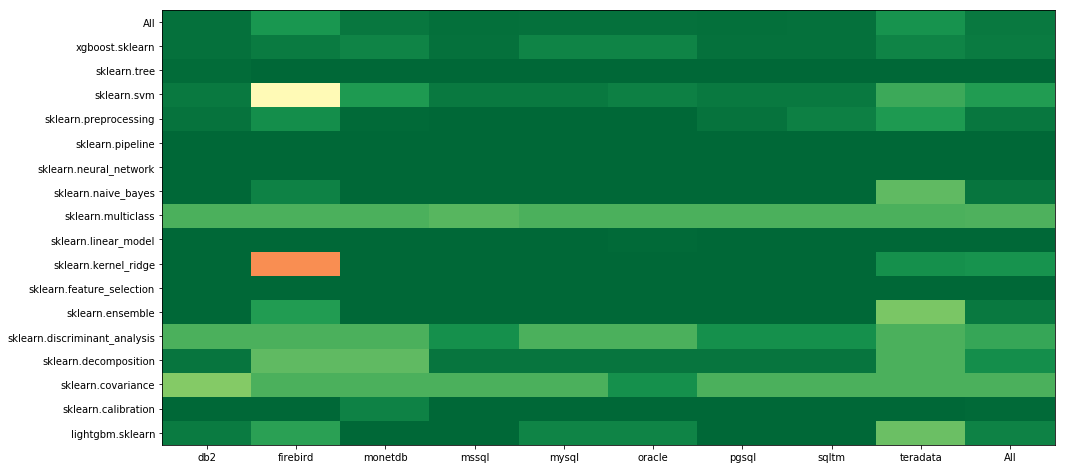

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn' , vmin=0 , vmax=1)
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  46
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'firebird', SUCCESS                                                  42
            'DatabaseError:(fdb.fbcore.DatabaseError)                 6
'monetdb',  SUCCESS                                                  48
'mssql',    SUCCESS                                                  48
'mysql',    SUCCESS                                                  45
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'oracle',   SUCCESS                                                  45
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'pgsql',    SUCCESS                                                  48
'sqltm',    SUCCESS                                                  48
'teradata', SUCCESS                                                  38
            'DatabaseError:(teradata.api.DatabaseError)               7
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3

mean                                              \
dialect                   db2  firebird monetdb mssql     mysql    oracle   
Model                                                                       
LGBMClassifier       0.000000  0.222222     0.0   0.0  0.000000  0.000000   
LGBMClassifier_pipe  0.111111  0.000000     0.0   0.0  0.166667  0.166667   
LGBMRegressor        0.000000  0.166667     0.0   0.0  0.000000  0.000000   
LGBMRegressor_pipe   0.000000  0.166667     0.0   0.0  0.000000  0.000000   
All                  0.041667  0.125000     0.0   0.0  0.062500  0.062500   

                                                     
dialect             pgsql sqltm  teradata       All  
Model                                                
LGBMClassifier        0.0   0.0  0.166667  0.043210  
LGBMClassifier_pipe   0.0   0.0  0.333333  0.086420  
LGBMRegressor         0.0   0.0  0.000000  0.018519  
LGBMRegressor_pipe    0.0   0.0  0.166667  0.037037  
All                   0.0   0.0  0.208333  0.055556

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message                         
'db2',      SUCCESS                             36
'firebird', SUCCESS                             36
'monetdb',  SUCCESS                             34
            'IntegrityError:COMMIT:              2
'mssql',    SUCCESS                             36
'mysql',    SUCCESS                             36
'oracle',   SUCCESS                             36
'pgsql',    SUCCESS                             36
'sqltm',    SUCCESS                             36
'teradata', SUCCESS                             36

mean                                              \
dialect                      db2 firebird   monetdb mssql mysql oracle pgsql   
Model                                                                          
CalibratedClassifierCV       0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
CalibratedClassifierCV_pipe  0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
All                          0.0      0.0  0.055556   0.0   0.0    0.0   0.0   

                                                      
dialect                     sqltm teradata       All  
Model                                                 
CalibratedClassifierCV        0.0      0.0  0.006173  
CalibratedClassifierCV_pipe   0.0      0.0  0.006173  
All                           0.0      0.0  0.006173

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                         9
            'InternalError:(ibm_db_dbi.InternalError)                       2
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        10
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'monetdb',  SUCCESS                                                        10
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            TIMEOUT                                                         1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'mysql',    SUCCESS                                                        10
            1436, "Thread stack overrun:  1237888 bytes use...              2
'oracle',   SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird   monetdb     mssql     mysql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.166667  0.333333  0.333333   
EllipticEnvelope_pipe  0.166667  0.000000  0.166667  0.000000  0.000000   
All                    0.250000  0.166667  0.166667  0.166667  0.166667   

                                                                         
dialect                  oracle     pgsql     sqltm  teradata       All  
Model                                                                    
EllipticEnvelope       0.166667  0.333333  0.333333  0.333333  0.296296  
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  0.037037  
All                    0.083333  0.166667  0.166667  0.166667  0.166667

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'firebird', SUCCESS                                                  58
            'DatabaseError:(fdb.fbcore.DatabaseError)                12
            "DatabaseError:(fdb.fbcore.DatabaseError)                 2
'monetdb',  SUCCESS                                                  58
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             14
'mssql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'mysql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'oracle',   SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'pgsql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'sqltm',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'teradata', SUCCESS                                                  60
            TIMEOUT                                                   7
            'DatabaseError:(teradata.api.DatabaseError)               3
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2

mean                                                    \
dialect              db2  firebird   monetdb     mssql     mysql    oracle   
Model                                                                        
FactorAnalysis  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
FastICA         0.166667  0.333333  0.166667  0.166667  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
KernelPCA       0.000000  0.833333  0.000000  0.000000  0.000000  0.000000   
PCA             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
All             0.027778  0.194444  0.194444  0.027778  0.027778  0.027778   

                                                        
dialect            pgsql     sqltm  teradata       All  
Model                                                   
FactorAnalysis  0.000000  0.000000  0.333333  0.148148  
FastICA         0.166667  0.166667  0.166667  0.185185  
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  
KernelPCA       0.000000  0.000000  0.500000  0.148148  
PCA             0.000000  0.000000  0.000000  0.000000  
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  
All             0.027778  0.027778  0.166667  0.080247

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  30
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'firebird', SUCCESS                                                  30
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'monetdb',  SUCCESS                                                  30
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'mssql',    SUCCESS                                                  33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mysql',    SUCCESS                                                  30
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'oracle',   SUCCESS                                                  30
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'pgsql',    SUCCESS                                                  33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'sqltm',    SUCCESS                                                  33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'teradata', SUCCESS                                                  30
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6

mean                                \
dialect                               db2  firebird   monetdb     mssql   
Model                                                                     
LinearDiscriminantAnalysis       0.000000  0.000000  0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.333333  0.333333  0.333333  0.166667   
All                              0.166667  0.166667  0.166667  0.083333   

                                                                         \
dialect                             mysql    oracle     pgsql     sqltm   
Model                                                                     
LinearDiscriminantAnalysis       0.000000  0.000000  0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.333333  0.333333  0.166667  0.166667   
All                              0.166667  0.166667  0.083333  0.083333   

                                                     
dialect                          teradata       All  
Model                                                
LinearDiscriminantAnalysis       0.000000  0.000000  
LinearDiscriminantAnalysis_pipe  0.333333  0.277778  
All                              0.166667  0.138889

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 252
'firebird', SUCCESS                                                 224
            'DatabaseError:(fdb.fbcore.DatabaseError)                28
'monetdb',  SUCCESS                                                 252
'mssql',    SUCCESS                                                 252
'mysql',    SUCCESS                                                 252
'oracle',   SUCCESS                                                 252
'pgsql',    SUCCESS                                                 252
'sqltm',    SUCCESS                                                 252
'teradata', SUCCESS                                                 193
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             53
            'DatabaseError:(teradata.api.DatabaseError)               6

mean                                       \
dialect                          db2  firebird monetdb mssql mysql oracle   
Model                                                                       
AdaBoostClassifier               0.0  0.500000     0.0   0.0   0.0    0.0   
AdaBoostClassifier_pipe          0.0  0.444444     0.0   0.0   0.0    0.0   
AdaBoostRegressor                0.0  0.000000     0.0   0.0   0.0    0.0   
AdaBoostRegressor_pipe           0.0  0.000000     0.0   0.0   0.0    0.0   
BaggingClassifier                0.0  0.000000     0.0   0.0   0.0    0.0   
BaggingClassifier_pipe           0.0  0.000000     0.0   0.0   0.0    0.0   
BaggingRegressor                 0.0  0.000000     0.0   0.0   0.0    0.0   
BaggingRegressor_pipe            0.0  0.000000     0.0   0.0   0.0    0.0   
ExtraTreesClassifier             0.0  0.000000     0.0   0.0   0.0    0.0   
ExtraTreesClassifier_pipe        0.0  0.000000     0.0   0.0   0.0    0.0   
ExtraTreesRegressor              0.0  0.166667     0.0   0.0   0.0    0.0   
ExtraTreesRegressor_pipe         0.0  0.000000     0.0   0.0   0.0    0.0   
GradientBoostingClassifier       0.0  0.055556     0.0   0.0   0.0    0.0   
GradientBoostingClassifier_pipe  0.0  0.111111     0.0   0.0   0.0    0.0   
GradientBoostingRegressor        0.0  0.166667     0.0   0.0   0.0    0.0   
GradientBoostingRegressor_pipe   0.0  0.000000     0.0   0.0   0.0    0.0   
IsolationForest                  0.0  0.500000     0.0   0.0   0.0    0.0   
IsolationForest_pipe             0.0  0.500000     0.0   0.0   0.0    0.0   
RandomForestClassifier           0.0  0.000000     0.0   0.0   0.0    0.0   
RandomForestClassifier_pipe      0.0  0.000000     0.0   0.0   0.0    0.0   
RandomForestRegressor            0.0  0.000000     0.0   0.0   0.0    0.0   
RandomForestRegressor_pipe       0.0  0.000000     0.0   0.0   0.0    0.0   
All                              0.0  0.111111     0.0   0.0   0.0    0.0   

                                                                 
dialect                         pgsql sqltm  teradata       All  
Model                                                            
AdaBoostClassifier                0.0   0.0  0.277778  0.086420  
AdaBoostClassifier_pipe           0.0   0.0  0.277778  0.080247  
AdaBoostRegressor                 0.0   0.0  0.000000  0.000000  
AdaBoostRegressor_pipe            0.0   0.0  0.000000  0.000000  
BaggingClassifier                 0.0   0.0  0.333333  0.037037  
BaggingClassifier_pipe            0.0   0.0  0.333333  0.037037  
BaggingRegressor                  0.0   0.0  0.000000  0.000000  
BaggingRegressor_pipe             0.0   0.0  0.000000  0.000000  
ExtraTreesClassifier              0.0   0.0  0.444444  0.049383  
ExtraTreesClassifier_pipe         0.0   0.0  0.777778  0.086420  
ExtraTreesRegressor               0.0   0.0  0.000000  0.018519  
ExtraTreesRegressor_pipe          0.0   0.0  0.166667  0.018519  
GradientBoostingClassifier        0.0   0.0  0.000000  0.006173  
GradientBoostingClassifier_pipe   0.0   0.0  0.000000  0.012346  
GradientBoostingRegressor         0.0   0.0  0.000000  0.018519  
GradientBoostingRegressor_pipe    0.0   0.0  0.000000  0.000000  
IsolationForest                   0.0   0.0  0.666667  0.129630  
IsolationForest_pipe              0.0   0.0  0.666667  0.129630  
RandomForestClassifier            0.0   0.0  0.222222  0.024691  
RandomForestClassifier_pipe       0.0   0.0  0.111111  0.012346  
RandomForestRegressor             0.0   0.0  0.000000  0.000000  
RandomForestRegressor_pipe        0.0   0.0  0.000000  0.000000  
All                               0.0   0.0  0.234127  0.038360

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,108
"'firebird',",SUCCESS,108
"'monetdb',",SUCCESS,108
"'mssql',",SUCCESS,108
"'mysql',",SUCCESS,108
"'oracle',",SUCCESS,108
"'pgsql',",SUCCESS,108
"'sqltm',",SUCCESS,108
"'teradata',",SUCCESS,108


mean                                                  \
dialect                  db2 firebird monetdb mssql mysql oracle pgsql sqltm   
Model                                                                          
GenericUnivariateSelect    0        0       0     0     0      0     0     0   
RFE                        0        0       0     0     0      0     0     0   
RFECV                      0        0       0     0     0      0     0     0   
SelectFdr                  0        0       0     0     0      0     0     0   
SelectFpr                  0        0       0     0     0      0     0     0   
SelectFromModel            0        0       0     0     0      0     0     0   
SelectFwe                  0        0       0     0     0      0     0     0   
SelectKBest                0        0       0     0     0      0     0     0   
SelectPercentile           0        0       0     0     0      0     0     0   
All                        0        0       0     0     0      0     0     0   

                                      
dialect                 teradata All  
Model                                 
GenericUnivariateSelect        0   0  
RFE                            0   0  
RFECV                          0   0  
SelectFdr                      0   0  
SelectFpr                      0   0  
SelectFromModel                0   0  
SelectFwe                      0   0  
SelectKBest                    0   0  
SelectPercentile               0   0  
All                            0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 12
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                6
            "DatabaseError:(fdb.fbcore.DatabaseError)                3
            SUCCESS                                                  3
'monetdb',  SUCCESS                                                 12
'mssql',    SUCCESS                                                 12
'mysql',    SUCCESS                                                 12
'oracle',   SUCCESS                                                 12
'pgsql',    SUCCESS                                                 12
'sqltm',    SUCCESS                                                 12
'teradata', SUCCESS                                                 11
            'DatabaseError:(teradata.api.DatabaseError)              1

mean                                                  \
dialect           db2 firebird monetdb mssql mysql oracle pgsql sqltm   
Model                                                                   
KernelRidge       0.0     1.00     0.0   0.0   0.0    0.0   0.0   0.0   
KernelRidge_pipe  0.0     0.50     0.0   0.0   0.0    0.0   0.0   0.0   
All               0.0     0.75     0.0   0.0   0.0    0.0   0.0   0.0   

                                      
dialect           teradata       All  
Model                                 
KernelRidge       0.166667  0.129630  
KernelRidge_pipe  0.000000  0.055556  
All               0.083333  0.092593

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'firebird', SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'monetdb',  SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'mssql',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'mysql',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'oracle',   SUCCESS                                                       490
            'DatabaseError:(cx+Oracle.DatabaseError)                        1
            'cTrainingError:ValueError:`min_samples` may no...              1
'pgsql',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'sqltm',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'teradata', SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1

mean                                \
dialect                                db2  firebird   monetdb     mssql   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.000000  0.000000  0.000000  0.000000   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000  0.000000   
Lars                              0.000000  0.000000  0.000000  0.000000   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000  0.000000   
Lars_pipe                         0.000000  0.000000  0.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000  0.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLars_pipe                    0.000000  0.000000  0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000  0.000000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.000000  0.000000  0.000000  0.000000   
LogisticRegression                0.000000  0.000000  0.000000  0.000000   
LogisticRegressionCV              0.000000  0.000000  0.000000  0.000000   
LogisticRegressionCV_pipe         0.000000  0.000000  0.000000  0.000000   
LogisticRegression_pipe           0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
Perceptron                        0.000000  0.000000  0.000000  0.000000   
Perceptron_pipe                   0.000000  0.000000  0.000000  0.000000   
RANSACRegressor                   0.166667  0.166667  0.166667  0.166667   
RANSACRegressor_pipe              0.000000  0.000000  0.000000  0.000000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  0.000000  0.000000  0.000000   
RidgeClassifier_pipe              0.000000  0.000000  0.000000  0.000000   
Ridge_pipe                        0.000000  0.000000  0.000000  0.000000   
SGDClassifier                     0.000000  0.000000  0.000000  0.000000   
SGDClassifier_pipe                0.000000  0.000000  0.000000  0.000000   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   11
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'monetdb',  SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mssql',    SUCCESS                                                        59
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
            208, b"Invalid object name '##TMP_2018053110350...              1
'mysql',    SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'oracle',   SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'pgsql',    SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'sqltm',    SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'teradata', SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12

mean                                          \
dialect                        db2  firebird   monetdb     mssql     mysql   
Model                                                                        
OneVsOneClassifier        0.333333  0.333333  0.333333  0.388889  0.333333   
OneVsOneClassifier_pipe   0.333333  0.333333  0.333333  0.333333  0.333333   
OneVsRestClassifier       0.000000  0.000000  0.000000  0.000000  0.000000   
OneVsRestClassifier_pipe  0.000000  0.000000  0.000000  0.000000  0.000000   
All                       0.166667  0.166667  0.166667  0.180556  0.166667   

                                                                            
dialect                     oracle     pgsql     sqltm  teradata       All  
Model                                                                       
OneVsOneClassifier        0.333333  0.333333  0.333333  0.333333  0.339506  
OneVsOneClassifier_pipe   0.333333  0.333333  0.333333  0.333333  0.333333  
OneVsRestClassifier       0.000000  0.000000  0.000000  0.000000  0.000000  
OneVsRestClassifier_pipe  0.000000  0.000000  0.000000  0.000000  0.000000  
All                       0.166667  0.166667  0.166667  0.166667  0.168210

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                           
'db2',      SUCCESS                                               72
'firebird', SUCCESS                                               68
            'DatabaseError:(fdb.fbcore.DatabaseError)              4
'monetdb',  SUCCESS                                               72
'mssql',    SUCCESS                                               72
'mysql',    SUCCESS                                               72
'oracle',   SUCCESS                                               72
'pgsql',    SUCCESS                                               72
'sqltm',    SUCCESS                                               72
'teradata', SUCCESS                                               58
            TIMEOUT                                               14

mean                                                   \
dialect          db2  firebird monetdb mssql mysql oracle pgsql sqltm   
Model                                                                   
BernoulliNB      0.0  0.000000     0.0   0.0   0.0    0.0   0.0   0.0   
GaussianNB       0.0  0.222222     0.0   0.0   0.0    0.0   0.0   0.0   
GaussianNB_pipe  0.0  0.000000     0.0   0.0   0.0    0.0   0.0   0.0   
MultinomialNB    0.0  0.000000     0.0   0.0   0.0    0.0   0.0   0.0   
All              0.0  0.055556     0.0   0.0   0.0    0.0   0.0   0.0   

                                     
dialect          teradata       All  
Model                                
BernoulliNB      0.333333  0.037037  
GaussianNB       0.333333  0.061728  
GaussianNB_pipe  0.111111  0.012346  
MultinomialNB    0.000000  0.000000  
All              0.194444  0.027778

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,48
"'firebird',",SUCCESS,48
"'monetdb',",SUCCESS,48
"'mssql',",SUCCESS,48
"'mysql',",SUCCESS,48
"'oracle',",SUCCESS,48
"'pgsql',",SUCCESS,48
"'sqltm',",SUCCESS,48
"'teradata',",SUCCESS,48


mean                                                  \
dialect             db2 firebird monetdb mssql mysql oracle pgsql sqltm   
Model                                                                     
MLPClassifier         0        0       0     0     0      0     0     0   
MLPClassifier_pipe    0        0       0     0     0      0     0     0   
MLPRegressor          0        0       0     0     0      0     0     0   
MLPRegressor_pipe     0        0       0     0     0      0     0     0   
All                   0        0       0     0     0      0     0     0   

                                 
dialect            teradata All  
Model                            
MLPClassifier             0   0  
MLPClassifier_pipe        0   0  
MLPRegressor              0   0  
MLPRegressor_pipe         0   0  
All                       0   0

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,48
"'firebird',",SUCCESS,48
"'monetdb',",SUCCESS,48
"'mssql',",SUCCESS,48
"'mysql',",SUCCESS,48
"'oracle',",SUCCESS,48
"'pgsql',",SUCCESS,48
"'sqltm',",SUCCESS,48
"'teradata',",SUCCESS,48


mean                                                           \
dialect        db2 firebird monetdb mssql mysql oracle pgsql sqltm teradata   
Model                                                                         
FeatureUnion     0        0       0     0     0      0     0     0        0   
Pipeline         0        0       0     0     0      0     0     0        0   
Pipeline_pipe    0        0       0     0     0      0     0     0        0   
All              0        0       0     0     0      0     0     0        0   

                   
dialect       All  
Model              
FeatureUnion    0  
Pipeline        0  
Pipeline_pipe   0  
All             0

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       146
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              4
'firebird', SUCCESS                                                       138
            'DatabaseError:(fdb.fbcore.DatabaseError)                      12
'monetdb',  SUCCESS                                                       149
            TIMEOUT                                                         1
'mssql',    SUCCESS                                                       150
'mysql',    SUCCESS                                                       150
'oracle',   SUCCESS                                                       150
'pgsql',    SUCCESS                                                       146
            ) target lists can have at most 1664 entrie                     4
'sqltm',    SUCCESS                                                       142
            ) too many columns in result se                                 4
            ) too many terms in compound SELEC                              4
'teradata', SUCCESS                                                       134
            TIMEOUT                                                         8
            "DatabaseError:(teradata.api.DatabaseError)                     4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4

mean                                         \
dialect                   db2  firebird   monetdb mssql mysql oracle   
Model                                                                  
Binarizer            0.000000  0.000000  0.000000   0.0   0.0    0.0   
Imputer              0.000000  0.000000  0.000000   0.0   0.0    0.0   
LabelBinarizer       0.000000  0.000000  0.000000   0.0   0.0    0.0   
LabelEncoder         0.000000  0.000000  0.000000   0.0   0.0    0.0   
MaxAbsScaler         0.000000  0.000000  0.000000   0.0   0.0    0.0   
MinMaxScaler         0.000000  0.000000  0.000000   0.0   0.0    0.0   
Normalizer           0.000000  0.000000  0.000000   0.0   0.0    0.0   
OneHotEncoder        0.000000  0.000000  0.000000   0.0   0.0    0.0   
PolynomialFeatures   0.333333  0.333333  0.083333   0.0   0.0    0.0   
QuantileTransformer  0.000000  0.666667  0.000000   0.0   0.0    0.0   
RobustScaler         0.000000  0.000000  0.000000   0.0   0.0    0.0   
StandardScaler       0.000000  0.000000  0.000000   0.0   0.0    0.0   
All                  0.026667  0.080000  0.006667   0.0   0.0    0.0   

                                                             
dialect                 pgsql     sqltm  teradata       All  
Model                                                        
Binarizer            0.000000  0.000000  0.000000  0.000000  
Imputer              0.000000  0.000000  0.000000  0.000000  
LabelBinarizer       0.000000  0.000000  0.000000  0.000000  
LabelEncoder         0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler         0.000000  0.000000  0.333333  0.037037  
MinMaxScaler         0.000000  0.000000  0.000000  0.000000  
Normalizer           0.000000  0.000000  0.000000  0.000000  
OneHotEncoder        0.000000  0.000000  0.000000  0.000000  
PolynomialFeatures   0.333333  0.333333  0.333333  0.194444  
QuantileTransformer  0.000000  0.333333  0.666667  0.185185  
RobustScaler         0.000000  0.000000  0.000000  0.000000  
StandardScaler       0.000000  0.000000  0.000000  0.000000  
All                  0.026667  0.053333  0.106667  0.033333

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                150
            'IndexError:list                                         6
'firebird', SUCCESS                                                 75
            'DatabaseError:(fdb.fbcore.DatabaseError)               65
            "DatabaseError:(fdb.fbcore.DatabaseError)               10
            'IndexError:list                                         6
'monetdb',  SUCCESS                                                139
            TIMEOUT                                                 10
            'IndexError:list                                         6
            'DBAPIError:(builtins.BrokenPipeError)                   1
'mssql',    SUCCESS                                                150
            'IndexError:list                                         6
'mysql',    SUCCESS                                                150
            'IndexError:list                                         6
'oracle',   SUCCESS                                                148
            'IndexError:list                                         6
            TIMEOUT                                                  2
'pgsql',    SUCCESS                                                150
            'IndexError:list                                         6
'sqltm',    SUCCESS                                                150
            'IndexError:list                                         6
'teradata', SUCCESS                                                133
            TIMEOUT                                                 16
            'IndexError:list                                         6
            'DatabaseError:(teradata.api.DatabaseError)              1

mean                                                    \
dialect                db2  firebird   monetdb     mssql     mysql    oracle   
Model                                                                          
LinearSVC         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVC_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVC             0.166667  0.833333  0.277778  0.166667  0.166667  0.166667   
NuSVC_pipe        0.166667  0.833333  0.277778  0.166667  0.166667  0.166667   
NuSVR             0.000000  1.000000  0.166667  0.000000  0.000000  0.000000   
NuSVR_pipe        0.000000  0.166667  0.000000  0.000000  0.000000  0.000000   
OneClassSVM       0.000000  0.833333  0.000000  0.000000  0.000000  0.000000   
OneClassSVM_pipe  0.000000  0.166667  0.000000  0.000000  0.000000  0.000000   
SVC               0.000000  0.777778  0.166667  0.000000  0.000000  0.111111   
SVC_pipe          0.000000  0.833333  0.166667  0.000000  0.000000  0.000000   
SVR               0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
SVR_pipe          0.000000  0.500000  0.000000  0.000000  0.000000  0.000000   
All               0.038462  0.519231  0.108974  0.038462  0.038462  0.051282   

                                                          
dialect              pgsql     sqltm  teradata       All  
Model                                                     
LinearSVC         0.000000  0.000000  0.000000  0.000000  
LinearSVC_pipe    0.000000  0.000000  0.000000  0.000000  
LinearSVR         0.000000  0.000000  0.000000  0.000000  
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  
NuSVC             0.166667  0.166667  0.277778  0.265432  
NuSVC_pipe        0.166667  0.166667  0.166667  0.253086  
NuSVR             0.000000  0.000000  0.000000  0.129630  
NuSVR_pipe        0.000000  0.000000  0.000000  0.018519  
OneClassSVM       0.000000  0.000000  0.000000  0.092593  
OneClassSVM_pipe  0.000000  0.000000  0.000000  0.018519  
SVC               0.000000  0.000000  0.388889  0.160494  
SVC_pipe          0.000000  0.000000  0.388889  0.154321  
SVR               0.000000  0.000000  0.166667  0.129630  
SVR_pipe          0.000000  0.000000  0.000000  0.055556  
All               0.038462  0.038462  0.147436  0.113248

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        95
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        96
'monetdb',  SUCCESS                                                        96
'mssql',    SUCCESS                                                        96
'mysql',    SUCCESS                                                        96
'oracle',   SUCCESS                                                        96
'pgsql',    SUCCESS                                                        96
'sqltm',    SUCCESS                                                        96
'teradata', SUCCESS                                                        96

mean                                      \
dialect                           db2 firebird monetdb mssql mysql oracle   
Model                                                                       
DecisionTreeClassifier       0.000000      0.0     0.0   0.0   0.0    0.0   
DecisionTreeClassifier_pipe  0.000000      0.0     0.0   0.0   0.0    0.0   
DecisionTreeRegressor        0.000000      0.0     0.0   0.0   0.0    0.0   
DecisionTreeRegressor_pipe   0.166667      0.0     0.0   0.0   0.0    0.0   
ExtraTreeClassifier          0.000000      0.0     0.0   0.0   0.0    0.0   
ExtraTreeClassifier_pipe     0.000000      0.0     0.0   0.0   0.0    0.0   
ExtraTreeRegressor           0.000000      0.0     0.0   0.0   0.0    0.0   
ExtraTreeRegressor_pipe      0.000000      0.0     0.0   0.0   0.0    0.0   
All                          0.010417      0.0     0.0   0.0   0.0    0.0   

                                                            
dialect                     pgsql sqltm teradata       All  
Model                                                       
DecisionTreeClassifier        0.0   0.0      0.0  0.000000  
DecisionTreeClassifier_pipe   0.0   0.0      0.0  0.000000  
DecisionTreeRegressor         0.0   0.0      0.0  0.000000  
DecisionTreeRegressor_pipe    0.0   0.0      0.0  0.018519  
ExtraTreeClassifier           0.0   0.0      0.0  0.000000  
ExtraTreeClassifier_pipe      0.0   0.0      0.0  0.000000  
ExtraTreeRegressor            0.0   0.0      0.0  0.000000  
ExtraTreeRegressor_pipe       0.0   0.0      0.0  0.000000  
All                           0.0   0.0      0.0  0.001157

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'firebird', SUCCESS                                                  46
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
            'DatabaseError:(fdb.fbcore.DatabaseError)                 1
'monetdb',  SUCCESS                                                  45
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mssql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'mysql',    SUCCESS                                                  45
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'oracle',   SUCCESS                                                  45
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'pgsql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'sqltm',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'teradata', SUCCESS                                                  45
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3

mean                                          \
dialect                  db2  firebird   monetdb     mssql     mysql   
Model                                                                  
XGBClassifier       0.000000  0.000000  0.000000  0.000000  0.000000   
XGBClassifier_pipe  0.000000  0.000000  0.111111  0.000000  0.111111   
XGBRegressor        0.166667  0.333333  0.166667  0.166667  0.166667   
XGBRegressor_pipe   0.000000  0.000000  0.000000  0.000000  0.000000   
All                 0.020833  0.041667  0.062500  0.020833  0.062500   

                                                                      
dialect               oracle     pgsql     sqltm  teradata       All  
Model                                                                 
XGBClassifier       0.000000  0.000000  0.000000  0.000000  0.000000  
XGBClassifier_pipe  0.111111  0.000000  0.000000  0.111111  0.049383  
XGBRegressor        0.166667  0.166667  0.166667  0.166667  0.185185  
XGBRegressor_pipe   0.000000  0.000000  0.000000  0.000000  0.000000  
All                 0.062500  0.020833  0.020833  0.062500  0.041667

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect


'db2',


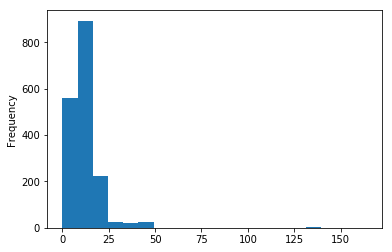

'firebird',


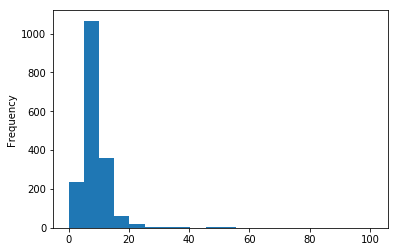

'monetdb',


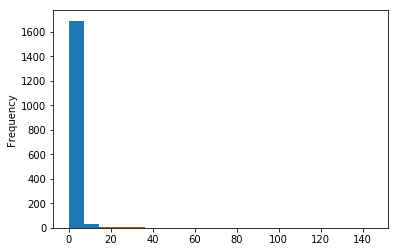

'mssql',


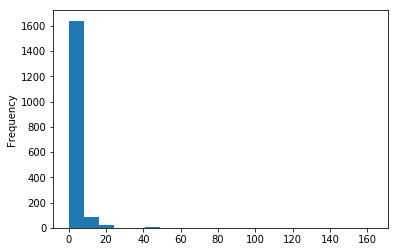

'mysql',


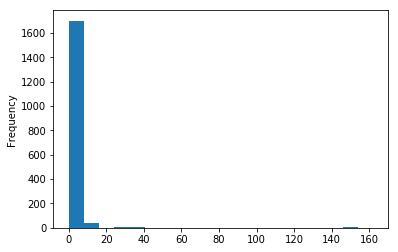

'oracle',


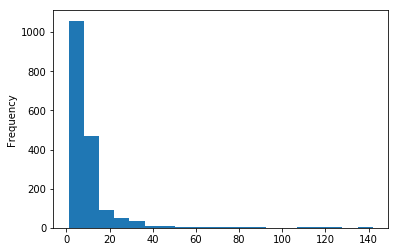

'pgsql',


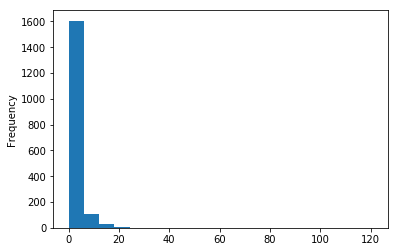

'sqltm',


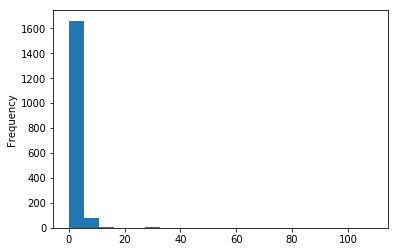

'teradata',


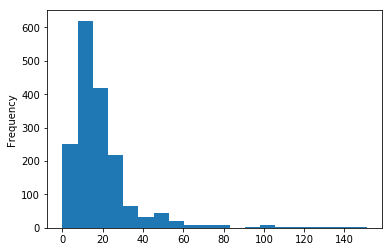

In [44]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.est_dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
